<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing Github connection


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "drive/My Drive/dataset/"

Long_words  Short_words


In [ ]:
import scipy.io
mat = scipy.io.loadmat("drive/My Drive/dataset/Long_words/sub_2b_ch64_l_eog_removed_256Hz")

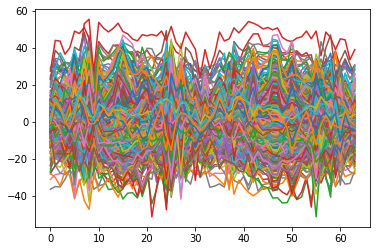

In [9]:
# Cooperate in resting state
numpy_array = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
plt.plot(numpy_array[0][0])
#plt.colorbar()
#plt.show()

 ...]

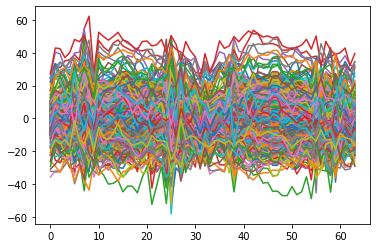

In [6]:
# Cooperate during speech imagery state
numpy_array_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
plt.plot(numpy_array_beep[0][0])

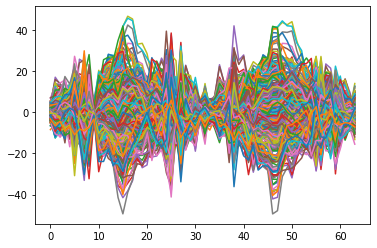

In [10]:
# Independent during resting state
numpy_array = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
plt.plot(numpy_array[0][1])

 ...]

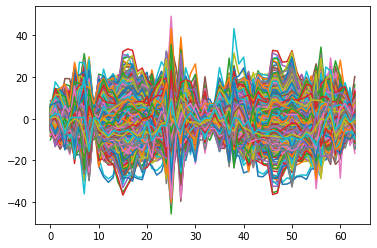

In [11]:
# Independent during speech imagery state
numpy_array_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
plt.plot(numpy_array_beep[0][1])

In [8]:
def loadMatrices():
    #here we load matrices from the dataset and perform co-varience operation on each
    matrices_list=[]
    covarience_matrices_list=[]
